In [17]:
import numpy as np
import torch
import numba
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
torch.manual_seed(0)

print("Numpy version", np.__version__)
print("Torch version", torch.__version__)
print("Numba version", numba.__version__)

Numpy version 1.18.1
Torch version 1.4.0
Numba version 0.47.0


In [18]:
from batchdilate import DTWShpTime

In [19]:
batch_size = 128
num_channels = 10 # different "parallel" timeseries
num_outputs = 50 # number of future timesteps predicted


loc = torch.tensor([1.] * num_outputs)
scale = torch.tensor([1.] * num_outputs)
prediction = torch.normal(mean=loc, std=scale).repeat(batch_size, num_channels, 1).to(device)
prediction.shape

torch.Size([128, 10, 50])

In [20]:
target = torch.sin(torch.arange(num_outputs).float()).repeat(batch_size, num_channels, 1).to(device)
target.shape

torch.Size([128, 10, 50])

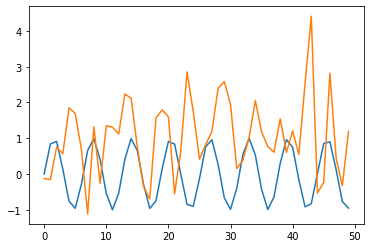

In [21]:
batch_id_to_plot = 0
channel_to_plot = 0
plt.plot(target[batch_id_to_plot, channel_to_plot].cpu().numpy())
plt.plot(prediction[batch_id_to_plot, channel_to_plot].cpu().numpy())

In [22]:
batch_dilate_loss_criterion = DTWShpTime(alpha=0.4, gamma=0.01)

total_loss, shape_loss, temporal_loss = batch_dilate_loss_criterion(prediction, target)

In [23]:
total_loss, shape_loss, temporal_loss

(tensor(21.7730, device='cuda:0'),
 tensor([53.7022, 53.7022, 53.7022, 53.7022, 53.7022, 53.7022, 53.7022, 53.7022,
         53.7022, 53.7022], device='cuda:0'),
 tensor([0.4868, 0.4868, 0.4868, 0.4868, 0.4868, 0.4868, 0.4868, 0.4868, 0.4868,
         0.4868], device='cuda:0'))

In [24]:
# verifying that total_loss = alpha * shape_loss + (1-alpha) * temporal_loss
assert torch.mean(0.4 * shape_loss + (1 - 0.4) * temporal_loss) == total_loss